<a href="https://colab.research.google.com/github/JairEsc/Mat_Apl_2/blob/main/Algoritmos_Gillespie.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Métodos de Gillespie

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Método de siguiente reacción sin redes

In [ ]:
def Gillespie_First_Reaction(N,X_S,X_I,beta,gamma,T=np.inf):
    #X_R=N-X_S-X_I
    #tiempo
    flag=True
    t=0
    Historia=[[0,X_S,X_I]]
    while(flag):
        tau=np.random.exponential(1/((beta/N)*X_S*X_I+gamma*X_I))
        p=np.random.uniform(0,1)
        if(p<(beta*X_S/N)/((beta/N)*X_S+gamma)):#Infeccion
            X_S+=-1
            X_I+=1
        else:
            X_I-=1
        t+=tau
        Historia.append([t,X_S,X_I])
        if(X_I==0 or t>T):
            flag=False
    return Historia

### Ejemplo

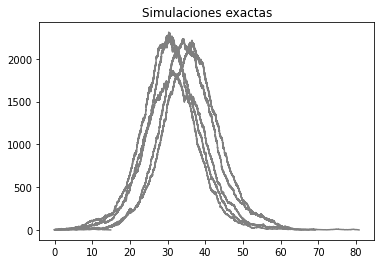

In [ ]:
N=10**5
S_0=N-2
I_0=N-S_0
beta=1.25
gamma=1
for k in range(10):
    H=Gillespie_First_Reaction(N,S_0,I_0,1.25,1)
    while(len(H)<10):
        H=Gillespie_First_Reaction(N,S_0,I_0,1.25,1)
    H=pd.DataFrame(H,columns=['time','S(t)','I(t)'])
    plt.plot(H['time'],H['I(t)'], 'gray')
plt.title('Simulaciones exactas')
plt.show()

## Método directo para SIR markoviano en redes

In [ ]:
import networkx as nx

In [ ]:
def update_dict_add(dict_num_contacts,k,s_i):
    u= dict_num_contacts[k].copy()
    u.append(s_i)
    dict_num_contacts[k]=u
    return dict_num_contacts

In [ ]:
def update_dict_remove(dict_num_contacts,k,s_i):
    u= dict_num_contacts[k].copy()
    u.remove(s_i)
    dict_num_contacts[k]=u
    return dict_num_contacts

In [ ]:
def Monte_Carlo_Step_exp(Lambdas,dict_num_contacts,X_I_indexes):
    Lambda=np.sum(Lambdas)
    tau=np.random.exponential(scale=1/Lambda)#Tiempo de siguiente reacción, hasta ahora desconocida.
    u_2=np.random.uniform(0,1)
    if(u_2<(Lambda-Lambdas[-1])/Lambda):#Infeccion
        u_3=np.random.uniform(0,1)
        D=0
        k=0
        while(u_3>D):
            k+=1
            D+=Lambdas[k]/(Lambda-Lambdas[-1])
        #k es el número de contactos infecciosos del seleccionado.
        #Seleccionamos uno aleatoriamente de ese grupo
        new_reaction=np.random.choice(dict_num_contacts[k])
    else:#Recuperación
        k=-1
        #Seleccionar un infeccioso al azar.
        new_reaction=np.random.choice(X_I_indexes)
    return tau,new_reaction,k
#Monte_Carlo_Step_exp(Lambdas)

In [ ]:
def Gillespie_Direct_Method_Network(beta,gamma,N,X_I_indexes,G_network_initial=nx.Graph(),T=np.inf):
    #X_R=N-X_S-X_I
    #tiempo
    flag=True
    t=0
    X_I=len(X_I_indexes)
    X_S=N-X_I
    Historia=[[0,X_S,X_I]]#Focus
    dict_num_contacts = dict.fromkeys(range(X_I+1),[])
    num_cont_inf_por_indice=np.zeros(N)
    for i in range(N):
        if(i not in X_I_indexes): #No es infeccioso
            count_for_i=0
            for j in X_I_indexes:
                if (G_network_initial.has_edge(i,j)):#Es un contacto Susceptible-infeccioso
                    num_cont_inf_por_indice[i]+=1#Ya que voy a hacer los ciclos, mejor la guardo igual.
                    count_for_i+=1
            dict_num_contacts=update_dict_add(dict_num_contacts,count_for_i,i)
    #print(dict_num_contacts)
    while(flag):
        #Generar las Lambdas------------------
        Lambda=0
        Lambdas=[]
        for k in range(len(list(dict_num_contacts.keys()))):
            Lambdas.append(beta*len(dict_num_contacts[k])*k)
            Lambda+=Lambdas[-1]
        Lambdas.append(gamma*X_I)
        Lambda+=Lambdas[-1]
        #------------------------------
        #Paso Monte-Carlo---------------------------
        tau,new_reaction,k_choice=Monte_Carlo_Step_exp(Lambdas,dict_num_contacts,X_I_indexes)
        #print("tiempo generado",tau,new_reaction)
        #-------------------------------------------
        #Actualización del sistema.
        if(G_network_initial.nodes[new_reaction]['Estado:']=='Susceptible'):
            G_network_initial.nodes[new_reaction]['Estado:']='Infeccioso'
            X_I_indexes=np.append(X_I_indexes,new_reaction)
            #print('Infeccion actualizada')
            i=new_reaction
            #print(new_reaction,' infectado al tiempo ', tau, ' del grupo ', 'k=',k_choice)
            dict_num_contacts=update_dict_remove(dict_num_contacts,k_choice,i)#Saca al nuevo infeccioso del conjunto con exactamente k_choice contactos infecciosos.
            #print("Si removido")
            #Ahora a todos los individuos que tenian contacto con el nuevo infeccioso, les aumentamos un contacto infeccioso.
            num_max_cont=list(dict_num_contacts.keys())[-1]
            for vecino in G_network_initial.neighbors(i):#Para cada vecino del nuevo infectado, le aumentamos el numero de contactos en 1. (lo agregamos a la siguiente categoria y lo sacamos de la anterior)
                if (G_network_initial.nodes[vecino]['Estado:']=='Susceptible'):
                    
                    num_cont_del_vecino=num_cont_inf_por_indice[vecino]
                    #print('el vecino ', vecino, ' del nuevo infectado ', i,' tiene ', num_cont_del_vecino,' contactos')
                    if(num_cont_del_vecino+1>num_max_cont):
                        dict_num_contacts.update({num_cont_del_vecino+1:[vecino]})
                    else:
                        dict_num_contacts=update_dict_add(dict_num_contacts,num_cont_del_vecino+1,vecino)
                    #print('el vecino ', vecino, ' ya no tiene ', num_cont_del_vecino, ' asi que lo borramos')
                    dict_num_contacts=update_dict_remove(dict_num_contacts,num_cont_del_vecino,vecino)
                    num_cont_inf_por_indice[vecino]+=1#Actualizamos ambas fuentes de informacion
        else:
            G_network_initial.nodes[new_reaction]['Estado:']='Recuperado'
            X_I_indexes=np.delete(X_I_indexes,np.where(X_I_indexes == new_reaction))#Vale la pena pasarlo a lista para usar remove()?
            #print('Recuperacion actualizada')
            i=new_reaction
            #Hay que actualizar los números de contactos de los susceptibles que tenían contacto con este infeccioso.
            for vecino in G_network_initial.neighbors(i):#Podria ser que ya no tuviera ningun contacto
                num_cont_del_vecino=num_cont_inf_por_indice[vecino]
                if(num_cont_del_vecino!=0):# no hay vecinos
                    dict_num_contacts=update_dict_add(dict_num_contacts,num_cont_del_vecino-1,vecino)
                    num_cont_inf_por_indice[vecino]-=1#Actualizamos ambas fuentes de informacion
        t+=tau
        X_I=len(X_I_indexes)
        X_S=N-X_I
        Historia.append([t,X_S,X_I])#Focus
        #print(X_S)
        #print(dict_num_contacts)
        if(X_I==0):
            flag=False
    return Historia
        #-------------------------------------------

## Ejemplo didáctico.

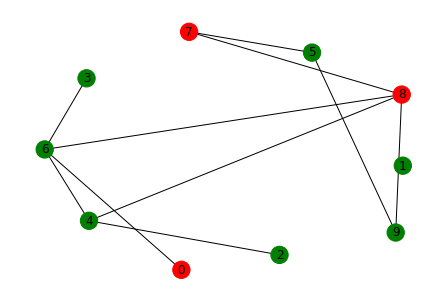

In [ ]:
N=10
ksum=1
np.random.seed(2)
while(ksum%2!=0):#Que defina una grafica.
        k_dist=np.random.poisson(2,size=N)
        ksum=sum(k_dist)
G=nx.random_degree_sequence_graph(k_dist)
pos=nx.spring_layout(G,seed=2,k=3)
X_I_indexes=np.random.choice(N,size=3,replace=False)
X_I=len(X_I_indexes)
for k in range(N):
    if k in X_I_indexes:
        G.nodes[k]['Estado:']='Infeccioso'
    else:
        G.nodes[k]['Estado:']='Susceptible'
nx.draw(G, pos,with_labels=True,node_color=['r' if G.nodes[i]['Estado:']=='Infeccioso' else 'g' if G.nodes[i]['Estado:']=='Susceptible' else 'gray' for i in range(N)])
dict_num_contacts = dict.fromkeys(range(X_I+1),[])
num_cont_inf_por_indice=np.zeros(N)
for i in range(N):
    if(i not in X_I_indexes): #No es infeccioso
        count_for_i=0
        for j in X_I_indexes:
            if (G.has_edge(i,j)):#Es un contacto Susceptible-infeccioso
                num_cont_inf_por_indice[i]+=1#Ya que voy a hacer los ciclos, mejor la guardo igual.
                count_for_i+=1
        dict_num_contacts=update_dict_add(dict_num_contacts,count_for_i,i)
#print(dict_num_contacts)

In [ ]:
dict_num_contacts

{0: [1, 2, 3], 1: [4, 5, 9], 2: [6], 3: []}

Los nodos $\{1, 2, 3\}$ tienen $0$ contactos infecciosos, i.e. Tasa $0$.

Los  nodos $\{4, 5, 9\}$ tienen $1$ contacto infeccioso, i.e. Tasa $\beta$.

Los  nodos $\{6\}$ tienen $2$ contacto infeccioso, i.e. Tasa $2\beta$.

Los nodos $\{0,7,8\}$ son infecciosos, i.e. Tasa $\gamma$.


Entonces definimos 3 canales de rección "infeccion_1", "infeccion_2" y "recuperación" con tasas:
 
*    $\beta\cdot |\{4, 5, 9\}|=3\beta$
*   $2\cdot\beta \cdot |\{6\}|=2\beta$
*   $\gamma |\{0,7,8\}|=3\gamma$

Generamos un tiempo $\tau$ según una distribución exponencial de parámetro $\Lambda=3\beta +2\beta +3\gamma$.

Luego, decidimos el canal de reacción que generó dicho tiempo.

Supongamos que elegimos el canal "infeccion_1", entonces sabemos que uno de los individuos del conjunto $\{4, 5, 9\}$ fue el infectado, como no sabemos quién, lo elegimos aleatoriamente porque tienen el mismo riesgo (están en el mismo conjunto).

### Ejemplo

In [ ]:
N=10**3
ksum=1
while(ksum%2!=0):#Que defina una grafica.
        k_dist=np.random.poisson(10,size=N)
        ksum=sum(k_dist)
G=nx.random_degree_sequence_graph(k_dist)
np.random.seed(0)
X_I_indexes=np.random.choice(N,size=5,replace=False)
for k in range(N):
    if k in X_I_indexes:
        G.nodes[k]['Estado:']='Infeccioso'
    else:
        G.nodes[k]['Estado:']='Susceptible'

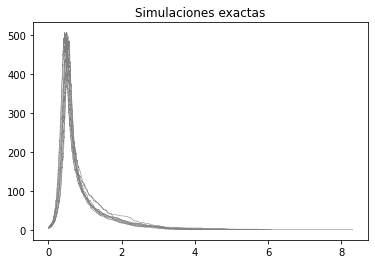

In [ ]:
S_0=N-5
I_0=N-S_0
beta=1.25
gamma=1
for k in range(10):
    H=[]
    G_copy=G.copy()
    while(len(H)<20):
        H=Gillespie_Direct_Method_Network(beta=beta,gamma=gamma,N=N,X_I_indexes=X_I_indexes,G_network_initial=G_copy,T=np.inf)
    H=pd.DataFrame(H,columns=['time','S(t)','I(t)'])
    plt.plot(H['time'],H['I(t)'], 'gray',linewidth=0.5)
plt.title('Simulaciones exactas')
plt.show()

## Método directo para SIR no-markoviano.



## Ejercicio didáctico para no-markoviano

Supongamos $X_I$ individuos infectados. No hay dinámica de contagio. 

Caso 1. Aplicación de una vacuna. 

Por ejemplo, si conocemos que una vacuna se aplicará aleatoriamente según una distribución no exponencial.

Sea $\psi_R$ la f.d.p. de tiempos de inter-ocurrencia de recuperación (o aplicación de la vacuna). Naturalmente, aquí, el tiempo de la siguiente recuperación depende del tiempo de la última recuperación, sin embargo, este ejemplo es sencilo porque solamente hay un canal de reacción ($M=1$) porque el evento es: Aplicar vacuna aleatoriamente (la aplicación no considera el tiempo que llevas enfermo, es decir, no hay prioridad. El caso siguiente cubre ese caso).

Formalmente, sea $t_u$ el tiempo de la última recuperación. La condición inicial del sistema es $t_u=0$. 

Como sabemos, hace falta calcular $$\Phi(\tau)=\prod \limits_{j=1}^M \frac{\Psi_j(\tilde{t}_j +\tau) }{\Psi_j(\tilde{t}_j)},$$
donde $\Psi_j(t)$ es la función de supervivencia de la densidad $\psi_j$,
y resolver $\Phi(\tau)=u$ donde $u\sim U(0,1)$.

Como $M=1$, $\Phi(\tau)=\frac{\Psi_R(t_u+\tau)}{\Psi_R(t_u)}$, con $\Psi_R(t)$ la función de supervivencia de la f.d.p. $\psi_R$. Trivialmente, definimos el algoritmo



0.   Inicializar $t_u=0$.
1.   Calcular $\Phi(\tau|t_u)$ como en la ecuación.
2.   Generar $u$ con distribución uniforme en (0,1) y resolver para $\tau$ la ecuación $\Phi(\tau|t_u)=u$.
3.   Actualizar $X_I=X_I-1$
4.   Actualizar $t_u=t_u+\tau$
5.   Volver al paso 1 hasta que $X_I=0$

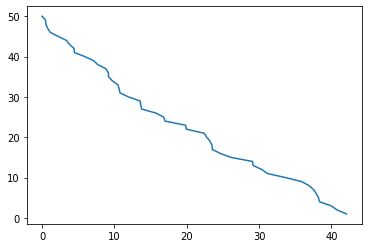

In [ ]:
#Ejemplo Caso 1.
lammbda=1
a=1.1
def pdf_Weibull(x,lammbda=lammbda,a=a):
    # a=1 es una exponencial.
    return (lammbda*a)*(lammbda*x)**(a-1)*np.exp(-(lammbda*x)**(a))
def survival_Weibull(x,lammbda=lammbda,a=a):
    return np.exp(-(lammbda*x)**(a))
times_last_events=0
X_I=50
t=0
times_saver=[0]
for iter in range(49):
    u=np.random.uniform()
    tau=(1/lammbda)*((lammbda*times_last_events)**a-np.log(u))**(1/a)-times_last_events##La primera vez es solo una Weibull.
    #Solo hay un canal asi que no hay nada que elegir.
    X_I-=1
    times_last_events+=tau#El tiempo de la siguiente reacción depende del tiempo de la última reacción (No absoluto)
    t+=tau
    times_saver.append(t)
plt.plot(times_saver,np.arange(50,0,-1))
#No es comparable con el SIR (S_0=0)

$\textbf{Nota}$ Los tiempos son muy largos, porque aquí la vacuna se genera a tasa constante, sin importar el número de individuos infecciosos, sin embargo, el siguiente evento depende del tiempo de última reacción.

Caso 2. El siguiente caso debería ser análogo a la configuración del SIR con condiciones iniciales $S_0=0$, $N=X_I$. Que se puede interpretar como una cuarentena. Así, los eventos son únicamente de recuperación, y como son independientes, el tiempo de la última recuperación siempre es 0 para cada canal. En este caso, se reduce a generar los tiempos de recuperación de cada individuo y ordenarlos.

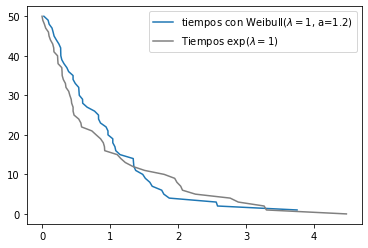

In [ ]:
lammbda=1
a=1.2
def pdf_Weibull(x,lammbda=lammbda,a=a):
    # a=1 es una exponencial.
    return (lammbda*a)*(lammbda*x)**(a-1)*np.exp(-(lammbda*x)**(a))
def survival_Weibull(x,lammbda=lammbda,a=a):
    return np.exp(-(lammbda*x)**(a))
times_last_events=np.zeros(50)
X_I=50
for iter in range(50):
    u=np.random.uniform(size=50)
    tau_s=(1/lammbda)*((lammbda*times_last_events)**a-np.log(u))**(1/a)-times_last_events##La primera vez es solo una Weibull.
    #Ahora, solo los acomodamos.
    times_saver=(np.sort(tau_s))# Notar que esto es equivalente a tomar minimos de subconjuntos de $k$ v.a.i.i.d. exponenciales, con k el numero de infecciosos restantes.
    #Como no hay distincion entre individuos, se recuperan aleatoriamete
plt.plot(times_saver,np.arange(50,0,-1),label='tiempos con Weibull('+'$\lambda=1$'+', a='+str(a)+')')
H=Gillespie_First_Reaction(N=X_I,X_S=0,X_I=X_I,beta=1.25,gamma=1)
H=pd.DataFrame(H,columns=['time','S(t)','I(t)'])
plt.plot(H['time'],H['I(t)'], 'gray',label='Tiempos exp('+'$\lambda=1$'+')')
plt.legend()
plt.show()

$\textbf{Nota.}$ Se parecen porque estamos tomando $a=1.2$, entonces la distribución Weibull se parece a una exponencial, además, los tiempos de la última reacción de cada canal son 0, así que no hay dependencia con el último evento.

Caso 3. SIR en una gráfica completa.

$\textbf{Nota para mí. }$Ya me queda más clara la conexión entre markoviano y Ley de Acción de Masas. 


Supongamos una población de $X_S$ individuos susceptibles y $X_I$ individuos infecciosos, sin redes. Si nos concentramos en un individuo susceptible, como no hay red (es equivalente a que hay una red completa (¿?)), tiene un posible contacto con cada uno de los infecciosos, con tasa instantánea $\beta$. Es decir, el tiempo de la siguiente infección con uno de estos infecciosos (seleccionado arbitrariamente) sigue una distribución exponencial de parámetro $\beta$, luego, el tiempo en el que tiene contacto con alguno de estos infecciosos (porque el mínimo de v.a. exponenciales independientes es exponencial de parámetro la suma de los parámetros) sigue una distribución exponencial de parámetro $\beta \cdot X_I$. Esto es para un susceptible cualquiera, así que el tiempo en el algún susceptible tiene contacto con algún infeccioso, por la misma propiedad; sigue una distribución exponencial de parámetro $\beta \cdot X_I\cdot X_S$.

## Ejemplo SIR, N=6 gráfica completa.

Tenemos $6(6-1)/2=15$ aristas y $6$ nodos, así que hay una cota superior para el número de canales de reacción de $6+15=21=:M.$

Los denotamos como $\{1,\ldots, M\}$ con distribuciones de tiempos de inter-ocurrencia $\psi_i$, que son de "contacto" o "recuperación" según el valor de $i$. Además, voy a considerar que cuando un individuo se infecta, la dinámica de sus contactos se reinicia, es decir, que no consideramos los contactos que tienen individuos susceptibles entre ellos antes de ser infecciosos.

Condicion inicial: Nodo 0 infeccioso
Al tiempo [20.3267078] ocurre una infeccion en el nodo 2


/usr/local/lib/python3.9/dist-packages/scipy/optimize/_minpack_py.py:178: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


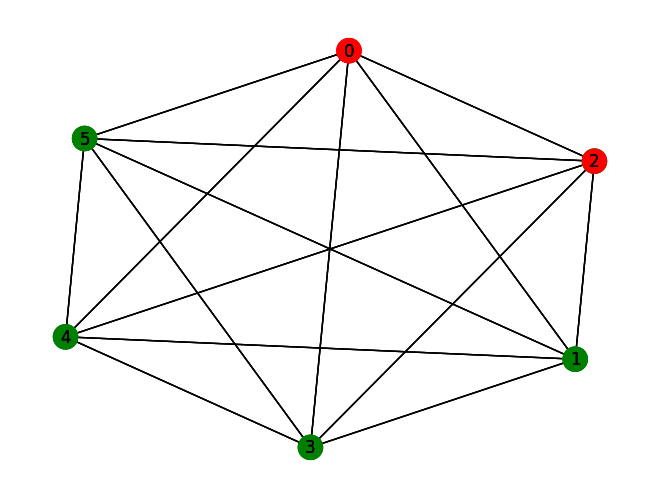

Al tiempo [11.51732356] ocurre una infeccion en el nodo 1


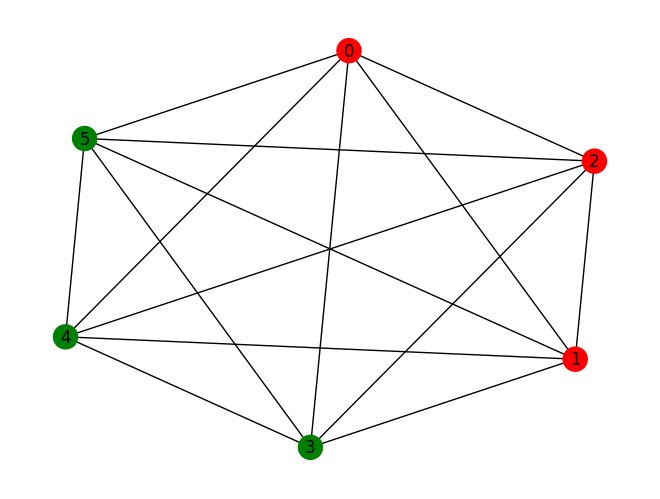

Al tiempo [8.29348514] ocurre una infeccion en el nodo 4


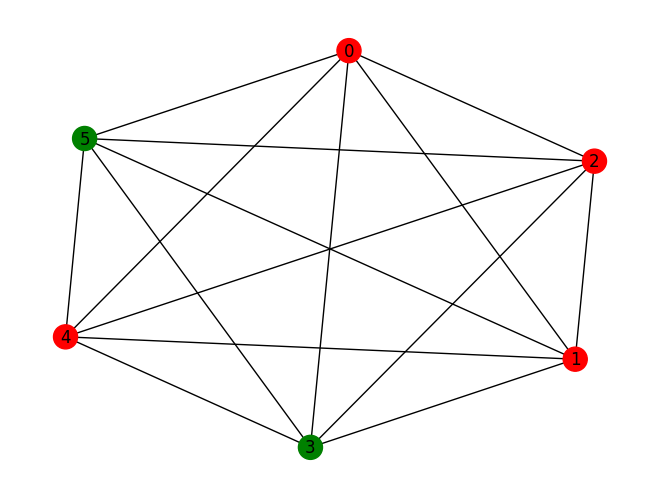

Al tiempo [6.58742769] ocurre una infeccion en el nodo 3


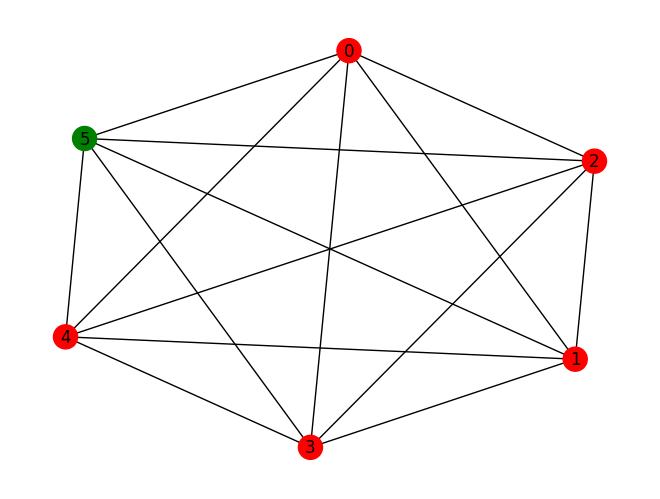

Al tiempo [5.52093897] ocurre una infeccion en el nodo 5


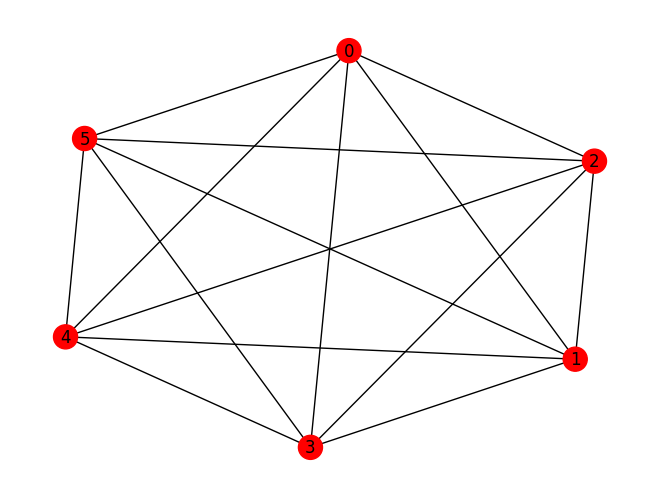

ValueError: ignored

In [2]:
from scipy.optimize import fsolve
import networkx as nx
N=6
G=nx.complete_graph(n=N)
pos=nx.spring_layout(G,seed=3,k=3)
X_I_indexes=[0]
for k in range(N):
    if k in X_I_indexes:
        G.nodes[k]['Estado:']='Infeccioso'
    else:
        G.nodes[k]['Estado:']='Susceptible'
nx.draw(G, pos,with_labels=True,node_color=['r' if G.nodes[i]['Estado:']=='Infeccioso' else 'g' if G.nodes[i]['Estado:']=='Susceptible' else 'gray' for i in range(N)])
M_max=len(G.edges)+N
lammbda_I=1.25
a_I=1.2
lammbda_R=1
a_R=1.2
def pdf_Weibull_I(x,lammbda=lammbda_I,a=a_I):
    # a=1 es una exponencial.
    return (lammbda*a)*(lammbda*x)**(a-1)*np.exp(-(lammbda*x)**(a))
def survival_Weibull_I(x,lammbda=lammbda_I,a=a_I):
    return np.exp(-(lammbda*x)**(a))
def pdf_Weibull_R(x,lammbda=lammbda_R,a=a_R):
    # a=1 es una exponencial.
    return (lammbda*a)*(lammbda*x)**(a-1)*np.exp(-(lammbda*x)**(a))
def survival_Weibull_R(x,lammbda=lammbda_R,a=a_R):
    return np.exp(-(lammbda*x)**(a))

times_last_events=np.zeros(M_max)#Inicializamos los tiempos de ultima reaccion
X_I=1
X_S=N-X_I
X_I_indexes=[0]
times_saver=[0]
t=0
for iter in range(7):
    if(iter==0):
        print('Condicion inicial: Nodo ' +str(X_I_indexes[0])+' infeccioso')
        nx.draw(G, pos,with_labels=True,node_color=['r' if G.nodes[i]['Estado:']=='Infeccioso' else 'g' if G.nodes[i]['Estado:']=='Susceptible' else 'gray' for i in range(N)])
    aristas_posible_infeccion=X_I*X_S
    def Phi(tau):
        S_1=0# Si los ultimos tiempos de reaccion son cero.
        S_2=aristas_posible_infeccion*((tau)**a_I)
        C_3=X_I*(tau**(a_R))
        return np.exp((lammbda_I**(a_I))*(S_1-S_2)-(lammbda_R**(a_R))*C_3)
    u=np.random.uniform()
    tau=fsolve(Phi,0.5)#Tiempo de la siguiente reaccion.
    #Paso Monte-Carlo--------------
    u_2=np.random.uniform()
    #Definicion de las probabilidades de canal de reaccion
    phi_s=np.zeros(aristas_posible_infeccion+X_I)#M numero de canales de reaccion posibles.
    for j in range(aristas_posible_infeccion):
        phi_s[j]=(pdf_Weibull_I(tau,lammbda=lammbda_I,a=a_I)/survival_Weibull_I(tau,lammbda=lammbda_I,a=a_I))*u
    for j in range(X_I):
        phi_s[j+aristas_posible_infeccion]=(pdf_Weibull_R(tau,lammbda=lammbda_R,a=a_R)/survival_Weibull_R(tau,lammbda=lammbda_R,a=a_R))*u
    pi_s=phi_s/(np.sum(phi_s))
    D=pi_s[0]
    k=0
    while(u_2>D):
        k+=1
        D+=pi_s[k]
    #k es el canal de reaccion. 
    #Como es grafica completa, esta facil: Si es menor que N*X_I, es una infeccion y elegimos a un susceptible al azar
    #Si es mayor o igual, es una recuperacion y elegimos un infeccoisos al azar
    if(k<aristas_posible_infeccion):#Infeccion
        #Seleccionamos un susceptible al azar. 
        selected=np.random.choice([i for i in range(N) if i not in X_I_indexes])
        G.nodes[selected]['Estado:']='Infeccioso'
        X_I_indexes=np.append(X_I_indexes,selected)
        X_I+=1
        print("Al tiempo "+str(t+tau)+' ocurre una infeccion en el nodo '+str(selected))
    else:
        selected=np.random.choice(X_I_indexes)
        G.nodes[selected]['Estado:']='Recuperado'
        X_I_indexes=np.delete(X_I_indexes,np.where(X_I_indexes == selected))
        X_I-=1
        print("Al tiempo "+str(t+tau)+' ocurre una recuperacion  del nodo '+str(selected))    
    nx.draw(G, pos,with_labels=True,node_color=['r' if G.nodes[i]['Estado:']=='Infeccioso' else 'g' if G.nodes[i]['Estado:']=='Susceptible' else 'gray' for i in range(N)])
    plt.show()


## Método directo para SIS no-markoviano. (de ser posible)


## Método directo para SIR no-markoviano en redes

## Explicación. 
Para cada individuo "en riesgo", es decir, con al menos un posible contacto infeccioso, existe una colección de aristas que lo conectan con estos indiviudos infeccciosos.

Sea $E_I=\{e_1,\ldots, e_{M_1}\}$ el conjunto de aristas que involucran u individuo susceptible y uno infeccioso, es decir, $e_i=(v_{1i},v_{2i})$, sin pérdida de  generalidad, con $v_{1i}$ infeccioso y $v_{2i}$ susceptible.


Además, sea $V_R=\{v_{i_1},\ldots,v_{i_{X_I} }\}$ el conjunto de nodos infecciosos, donde $i_1 < i_2<\cdots<i_{X_I}$ es un ordenamiento del número de infecciosos $X_I(t)$

Ahora, definimos los canales de reacción como el conjunto de índices $\{1,\ldots, M\}$, donde $M=M_1+X_I$. De esta manera, las posibles reacciones corresponden a la infección de un individuo susceptible a través de una de las aristas que lo conectan a un idividuo infeccioso, así como la recuperación de un nodo infeccioso. 

A diferencia del algoritmo de Gillespie original, ni los contactos ni la recuperación de los individuos se simulan como procesos de Poisson, es decir, no suponemos que los tiempos inter-ocurrencia se distribuyen como exponenciales de parámetros $\beta$ y $\gamma$ respectivamente. En cambio, cada arista tiene asociada una distribución de tiempos de inter-ocurrencia, así como los tiempos de recuperación siguen una distribución propia, en principio, distintas a la exponencial. \\ 

En su forma más general, podríamos considerar $N+|E|$ distintas distribuciones, es decir, una para cada recuperación de un indiviuo, así como una distribución distinta para cada interacción entre dos individuos, es decir, una arista, de las cuales hay $|E|$. Para simplificar, podemos suponer que la población es homogénea, en el sentido de que cada individuo posee las mismas características y se comporta de la misma manera, y reducir el número de distribuciones consideradas a $2$, es decir, una para los tiempos de infección a través de contacto por una arista, y otra para los tiempos de recuperación de nodos infecciosos.


Sean $\phi_I$ y $\phi_R$ las f.d.p. de los tiempos de inter-ocurrencia de los eventos de infección y recuperación, respectivamente. 
Suponemos que $\phi_R$ modela los tiempos inter-evento de contacto entre dos individuos, uno susceptible y uno infeccioso, mientras que $\phi_I$ modela los tiempos de inter-evento de recuperación.


In [ ]:
from scipy.optimize import fsolve
import networkx as nx
N=6
G=nx.complete_graph(n=N)

In [ ]:
G.edges(1)

EdgeDataView([(1, 0), (1, 2), (1, 3), (1, 4), (1, 5)])

In [ ]:
(0,1)[-1:-1]

()

In [ ]:
min(10,1)


1

In [ ]:
from scipy.optimize import fsolve
import networkx as nx
N=6
G=nx.complete_graph(n=N)
pos=nx.spring_layout(G,seed=3,k=3)
X_I_indexes=[0]
for k in range(N):
    if k in X_I_indexes:
        G.nodes[k]['Estado:']='Infeccioso'
    else:
        G.nodes[k]['Estado:']='Susceptible'
nx.draw(G, pos,with_labels=True,node_color=['r' if G.nodes[i]['Estado:']=='Infeccioso' else 'g' if G.nodes[i]['Estado:']=='Susceptible' else 'gray' for i in range(N)])
M_max=len(G.edges)+N
lammbda_I=1.25
a_I=1.2
lammbda_R=1
a_R=1.2
def pdf_Weibull_I(x,lammbda=lammbda_I,a=a_I):
    # a=1 es una exponencial.
    return (lammbda*a)*(lammbda*x)**(a-1)*np.exp(-(lammbda*x)**(a))
def survival_Weibull_I(x,lammbda=lammbda_I,a=a_I):
    return np.exp(-(lammbda*x)**(a))
def pdf_Weibull_R(x,lammbda=lammbda_R,a=a_R):
    # a=1 es una exponencial.
    return (lammbda*a)*(lammbda*x)**(a-1)*np.exp(-(lammbda*x)**(a))
def survival_Weibull_R(x,lammbda=lammbda_R,a=a_R):
    return np.exp(-(lammbda*x)**(a))

times_since_last_events=np.zeros(M_max)#Inicializamos los tiempos de ultima reaccion
X_I=1
X_S=N-X_I
X_I_indexes=[0]
times_saver=[0]
canales_reaccion_aristas=[]
canales_reaccion_vertices=X_I_indexes
for i in range(N):
        if(i not in X_I_indexes): #No es infeccioso
            count_for_i=0
            for j in X_I_indexes:
                if (G.has_edge(i,j)):#Es un contacto Susceptible-infeccioso
                    canales_reaccion_aristas.append((min(i,j),max(i,j)))
t=0
t_j_since_last_aristas=np.zeros(len(canales_reaccion_aristas))
t_j_since_last_vertices=np.zeros(X_I)
for iter in range(7):
    if(iter==0):
        print('Condicion inicial: Nodo ' +str(X_I_indexes[0])+' infeccioso')
        nx.draw(G, pos,with_labels=True,node_color=['r' if G.nodes[i]['Estado:']=='Infeccioso' else 'g' if G.nodes[i]['Estado:']=='Susceptible' else 'gray' for i in range(N)])
    #Suponemos actualizado times_since_last_events (2)
    def Phi(tau):
        S_1=np.sum(t_j_since_last_aristas**a_I)
        S_2=np.sum((tau+t_j_since_last_vertices)**a_R)
        C_3=X_I*(tau**(a_R))
        return np.exp((lammbda_I**(a_I))*(S_1-S_2)-(lammbda_R**(a_R))*C_3)
    u=np.random.uniform()
    tau=fsolve(Phi,0.5)#Tiempo de la siguiente reaccion.
    #Paso Monte-Carlo--------------
    u_2=np.random.uniform()
    #Definicion de las probabilidades de canal de reaccion
    phi_s=np.zeros(len(t_j_since_last_aristas)+X_I)#M numero de canales de reaccion posibles.
    for j in range(len(t_j_since_last_aristas)):
        phi_s[j]=(pdf_Weibull_I(tau+t_j_since_last_aristas[j],lammbda=lammbda_I,a=a_I)/survival_Weibull_I(tau+t_j_since_last_aristas[j],lammbda=lammbda_I,a=a_I))*u
    for j in range(X_I):
        phi_s[j+len(t_j_since_last_vertices)]=(pdf_Weibull_R(tau+t_j_since_last_vertices[j],lammbda=lammbda_R,a=a_R)/survival_Weibull_R(tau+t_j_since_last_vertices[j],lammbda=lammbda_R,a=a_R))*u
    pi_s=phi_s/(np.sum(phi_s))
    D=pi_s[0]
    k=0
    while(u_2>D):
        k+=1
        D+=pi_s[k]
    #k es el canal de reaccion. 
    #Como es grafica completa, esta facil: Si es menor que N*X_I, es una infeccion y elegimos a un susceptible al azar
    #Si es mayor o igual, es una recuperacion y elegimos un infeccoisos al azar
    t_j_since_last_aristas+=tau#Actualizo todas.
    t_j_since_last_vertices+=tau#Actualizo todos los infecciosos.
    if(k<len(t_j_since_last_aristas)):#Infeccion
        #Seleccionamos un susceptible al azar. 
        selected=canales_reaccion_aristas[k] #Es un par (v_1,v_2)
        if G.nodes[selected[0]]['Estado:']=='Infeccioso':
            G.nodes[selected[1]]['Estado:']='Infeccioso'
            selected_v=selected[1]
        else:
            G.nodes[selected[0]]['Estado:']='Infeccioso'
            selected_v=selected[0]
        print("Al tiempo "+str(t+tau)+' ocurre una infeccion en el nodo '+str(selected))
        ###Falta actualizar tiempos, y agregar nuevas aristas y quitas viejas aristas.

        t_j_since_last_vertices.append(0)#Agrego el nuevo con tiempo 0.
        X_I_indexes.append(selected_v)
        X_I+=1
        for i in range(len(canales_reaccion_aristas)):#Quiero quitar las aristas que involucran al nuevo infeccioso.
            e=canales_reaccion_aristas[i]
            if e[0]== selected_v or e[1] == selected_v:
                canales_reaccion_aristas.pop(i)
                t_j_since_last_aristas.pop(i)# y tambien su tiempo
        #Ahora quiero agregar las aristas que involucran al nuevo infeccioso y no estaban consideradas. 
        for edge in G.edges(selected_v):
            if edge not in canales_reaccion_aristas:
                canales_reaccion_aristas.append(edge)
                t_j_since_last_aristas.append(0)
    else:## Recuperacion
        index_vertice=k-len(t_j_since_last_aristas)
        selected=canales_reaccion_vertices[index_vertice]#Es el indice de un nodo.
        G.nodes[selected]['Estado:']='Recuperado'
        X_I_indexes.pop(index_vertice)
        t_j_since_last_vertices.pop(index_vertice)
        X_I-=1
        print("Al tiempo "+str(t+tau)+' ocurre una recuperacion  del nodo '+str(selected)) 
        ###Falta agregar nuevas aristas y quitas viejas aristas.
        for edge in G.edges(selected):
            if edge in canales_reaccion_aristas:
                canales_reaccion_aristas.append(edge)
                t_j_since_last_aristas.append(0)
    nx.draw(G, pos,with_labels=True,node_color=['r' if G.nodes[i]['Estado:']=='Infeccioso' else 'g' if G.nodes[i]['Estado:']=='Susceptible' else 'gray' for i in range(N)])
    plt.show()

### Pseudo-codigo (detallado).


Recibe: Una gráfica $G=(E,V)$, $E=\{(a,b)\}$ es el conjunto de aristas y $V=\{v_1,\ldots, v_n\}$ el conjunto de vértices. Condiciones iniciales $X(0)=(X_S(0),X_I(0),X_R(0))$ y funciones de densiad $\psi_I$ y $\psi_R$ para los tiempos inter-eventos de las infecciones y recuperaciones, respectivamente.


1.   

*   Inicializar $t=0$.
*   Definir 2 arreglos: 

    *    aristas_en_riesgo que contiene las aristas que podrían generar una infección, y su tiempo desde la última reacción. Default: tiempo=0.
    *    vertices_infecciosos que contiene los vértices que son infecciosos y su tiempo desde la última reacción. Default: tiempo=0.

2.   Sean $\{t_j\}$ los tiempos desde las últimas reacciones de ambos arreglos juntos. Definir la función $\Phi(\tau|\{t_j\})=\prod_j \frac{\Psi_j (\tau+t_j)}{\Psi_j(t_j)}$, donde $\Psi_j(r)=\int_r^\infty \psi_j(s)ds$, con $\psi_j=\psi_I$ ó $\psi_j=\psi_R$ según el valor de $j$.
3.   Generar $U\sim U(0,1)$ y resolver para $\tau$, $\Phi(\tau|\{t_j\})=u$.
4.   Definir las cantidades $\phi(\tau,i|t_i)=\frac{\psi_i(\tau+t_i)}{\Psi_i(\tau+t_i)}\cdot u$, para cada $i$.
5.   Calcular las probabilidades $\Pi_j(\tau)=\frac{\phi(\tau,j|t_j)}{\sum_j \phi(\tau,j|t_j)}$.
6.   Generar $u_2\sim U(0,1)$. Hallar el mínimo $j^*$ tal que 
$$\sum_{j=1}^{j^*-1} \Pi_j< u_2\leq \sum_{j=1}^{j^*} $$
7.   Identificar si $j^*$ corresponde a un elemento de la lista aristas_en_riesgo o  de la lista vertices_infecciosos. Según sea el caso: 

8.   Actualiza los tiempos desde la última reacción de los arreglos aristas_en_riesgo y vertices_infecciosos como $t_j=t_j+\tau$.
*   Si $j^*$ representa una arista: 
    * Identifica al individuo susceptible de esa arista y actualiza su estado a Infeccioso. 
    * Agrega a la lista vertices_infecciosos al nuevo infeccioso con tiempo 0.
    * Agrega a la lista aristas_en_riesgo a aquellas nuevas aristas que podrían provocar una infección, con tiempo 0.
    * Elimina de la lista aristas_en_riesgo a la arista que provocó la nueva infección.
    * Elimina de la lista aristas_en_riesgo a las aristas que ya no son viables. I.e. involucra a dos infecciosos.
*   Si $j^*$ representa un vértice: 
    * Actualiza el estado a Recuperado.
    * Elimina de la lista vertices_infecciosos al nuevo recuperado.
    * Elimina de la lista aristas_en_riesgo a aquellas aristas que involucran al nuevo recuperado.
9.   Vuelve al paso 2 hasta que el arreglo vertices_infecciosos sea vacío.






Listas llenadas:  {'arista': [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7)], 'tiempo': [0, 0, 0, 0, 0, 0, 0]} 
 {'vertice': [0], 'tiempo': [0]}
Así se ve la gráfica inicial: 



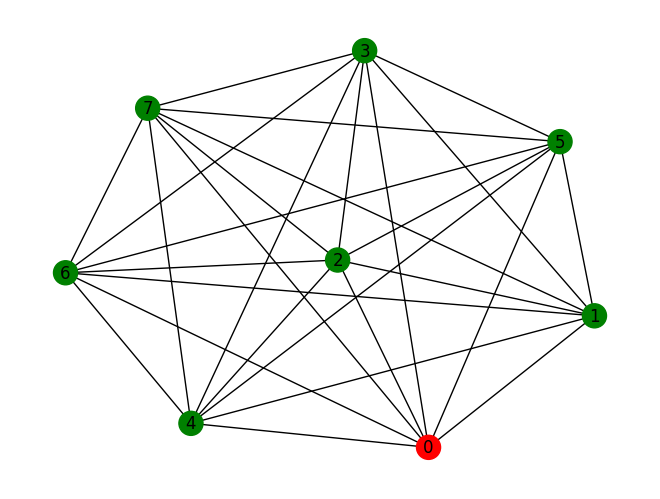

--------------------
------------------------------
Aristas en riesgo:  [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7)]
Vertices infecciosos:  [0]
------------------------------
------------------------------
En la siguiente iteración ocurre: 
 	 *Se genera el tiempo 0.06586410321850421
	 *Se selecciona el canal 2, que significa infeccion del individuo 3
------------------------------

 La grafica se ve asi: 


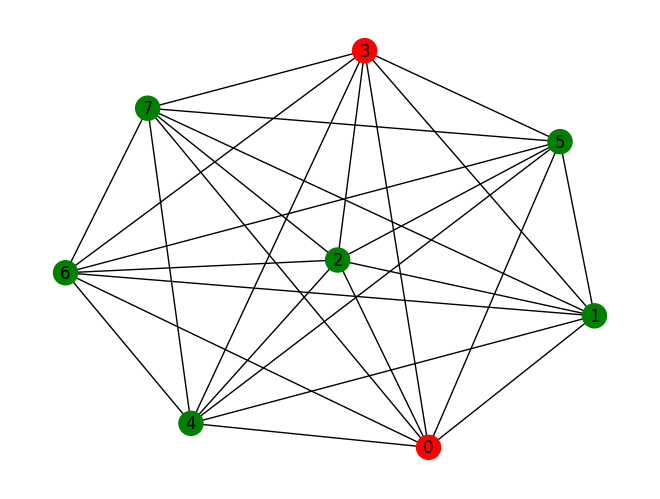

------------------------------
Aristas en riesgo:  [(0, 1), (0, 2), (0, 4), (0, 5), (0, 6), (0, 7), (1, 3), (2, 3), (3, 4), (3, 5), (3, 6), (3, 7)]
Vertices infecciosos:  [0, 3]
------------------------------
------------------------------
En la siguiente iteración ocurre: 
 	 *Se genera el tiempo 0.0956713134721297
	 *Se selecciona el canal 10, que significa infeccion del individuo 6
------------------------------

 La grafica se ve asi: 


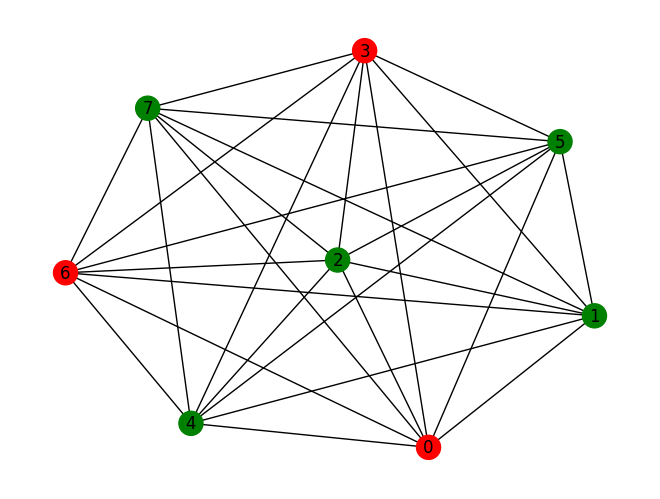

------------------------------
Aristas en riesgo:  [(0, 1), (0, 2), (0, 4), (0, 5), (0, 7), (1, 3), (2, 3), (3, 4), (3, 5), (3, 7), (1, 6), (2, 6), (4, 6), (5, 6), (6, 7)]
Vertices infecciosos:  [0, 3, 6]
------------------------------
------------------------------
En la siguiente iteración ocurre: 
 	 *Se genera el tiempo 0.18328051357000158
	 *Se selecciona el canal 13, que significa infeccion del individuo 5
------------------------------

 La grafica se ve asi: 


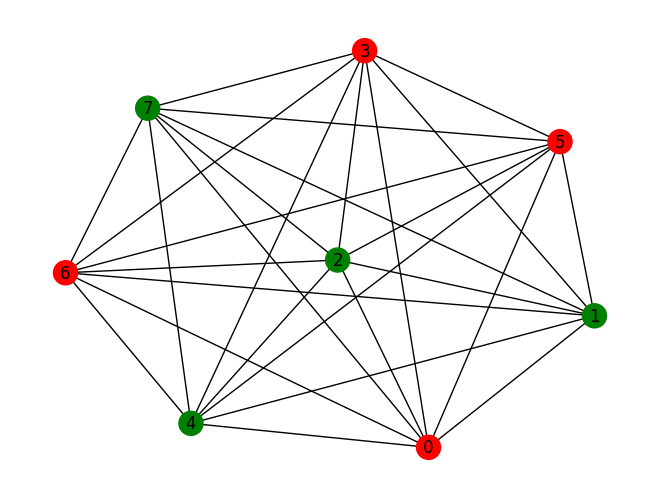

------------------------------
Aristas en riesgo:  [(0, 1), (0, 2), (0, 4), (0, 7), (1, 3), (2, 3), (3, 4), (3, 7), (1, 6), (2, 6), (4, 6), (6, 7), (1, 5), (2, 5), (4, 5), (5, 7)]
Vertices infecciosos:  [0, 3, 6, 5]
------------------------------
------------------------------
En la siguiente iteración ocurre: 
 	 *Se genera el tiempo 0.04092860143073034
	 *Se selecciona el canal 10, que significa infeccion del individuo 4
------------------------------

 La grafica se ve asi: 


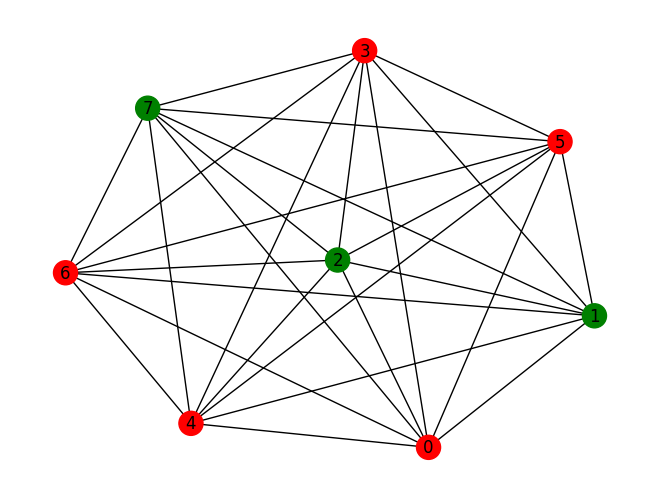

------------------------------
Aristas en riesgo:  [(0, 1), (0, 2), (0, 7), (1, 3), (2, 3), (3, 7), (1, 6), (2, 6), (6, 7), (1, 5), (2, 5), (5, 7), (1, 4), (2, 4), (4, 7)]
Vertices infecciosos:  [0, 3, 6, 5, 4]
------------------------------
------------------------------
En la siguiente iteración ocurre: 
 	 *Se genera el tiempo 0.017903499773992713
	 *Se selecciona el canal 1, que significa infeccion del individuo 2
------------------------------

 La grafica se ve asi: 


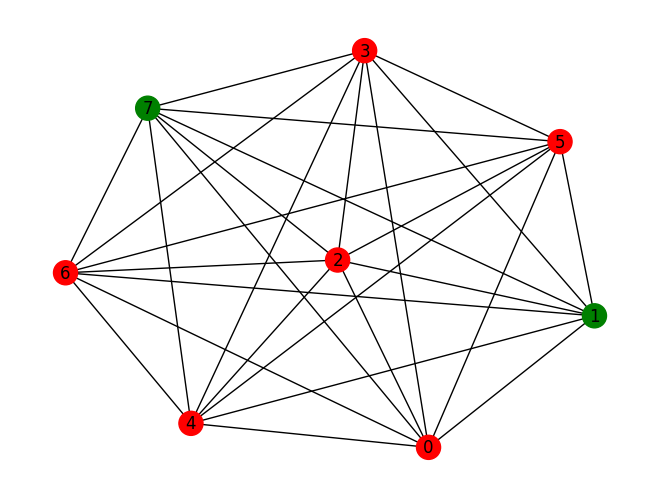

------------------------------
Aristas en riesgo:  [(0, 1), (0, 7), (1, 3), (3, 7), (1, 6), (6, 7), (1, 5), (5, 7), (1, 4), (4, 7), (1, 2), (2, 7)]
Vertices infecciosos:  [0, 3, 6, 5, 4, 2]
------------------------------
------------------------------
En la siguiente iteración ocurre: 
 	 *Se genera el tiempo 0.006243612186508941
	 *Se selecciona el canal 13, que significa recuperacion del individuo 3
------------------------------

 La grafica se ve asi: 


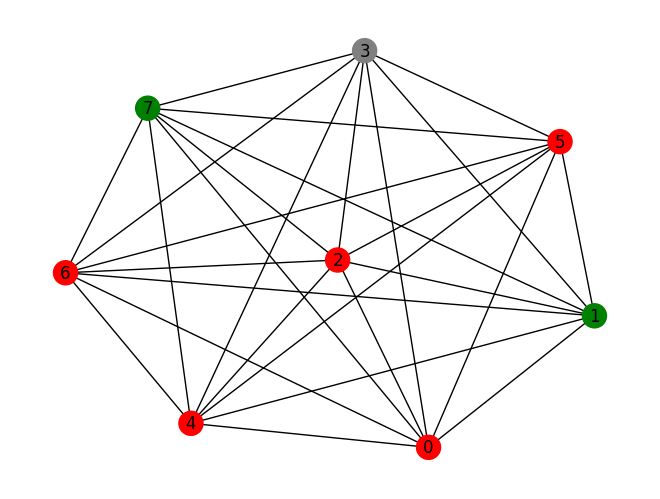

------------------------------
Aristas en riesgo:  [(0, 1), (0, 7), (1, 6), (6, 7), (1, 5), (5, 7), (1, 4), (4, 7), (1, 2), (2, 7)]
Vertices infecciosos:  [0, 6, 5, 4, 2]
------------------------------
------------------------------
En la siguiente iteración ocurre: 
 	 *Se genera el tiempo 0.06790214484503977
	 *Se selecciona el canal 2, que significa infeccion del individuo 1
------------------------------

 La grafica se ve asi: 


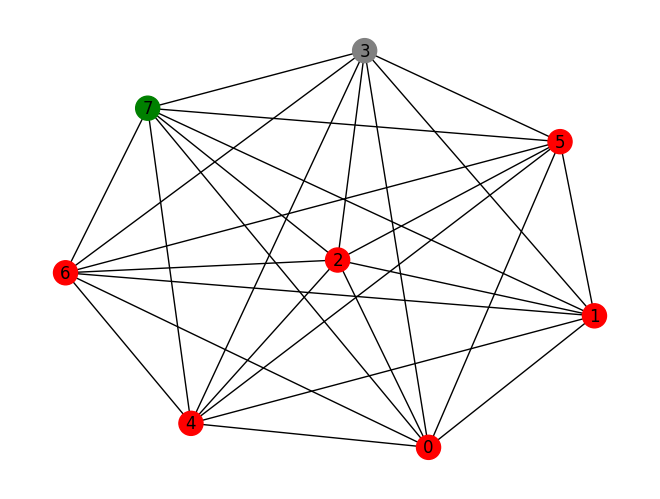

------------------------------
Aristas en riesgo:  [(0, 7), (6, 7), (5, 7), (4, 7), (2, 7), (1, 7)]
Vertices infecciosos:  [0, 6, 5, 4, 2, 1]
------------------------------
------------------------------
En la siguiente iteración ocurre: 
 	 *Se genera el tiempo 0.2206231341789599
	 *Se selecciona el canal 3, que significa infeccion del individuo 7
------------------------------

 La grafica se ve asi: 


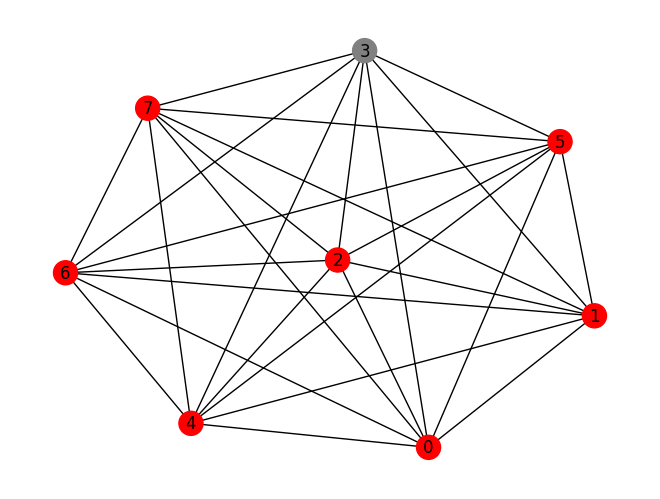

------------------------------
Aristas en riesgo:  []
Vertices infecciosos:  [0, 6, 5, 4, 2, 1, 7]
------------------------------
------------------------------
En la siguiente iteración ocurre: 
 	 *Se genera el tiempo 0.0514967288138884
	 *Se selecciona el canal 5, que significa recuperacion del individuo 1
------------------------------

 La grafica se ve asi: 


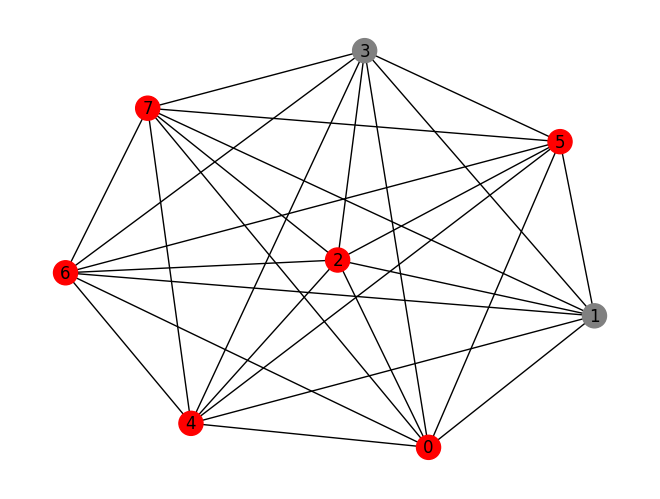

------------------------------
Aristas en riesgo:  []
Vertices infecciosos:  [0, 6, 5, 4, 2, 7]
------------------------------
------------------------------
En la siguiente iteración ocurre: 
 	 *Se genera el tiempo 0.1818556550653648
	 *Se selecciona el canal 1, que significa recuperacion del individuo 6
------------------------------

 La grafica se ve asi: 


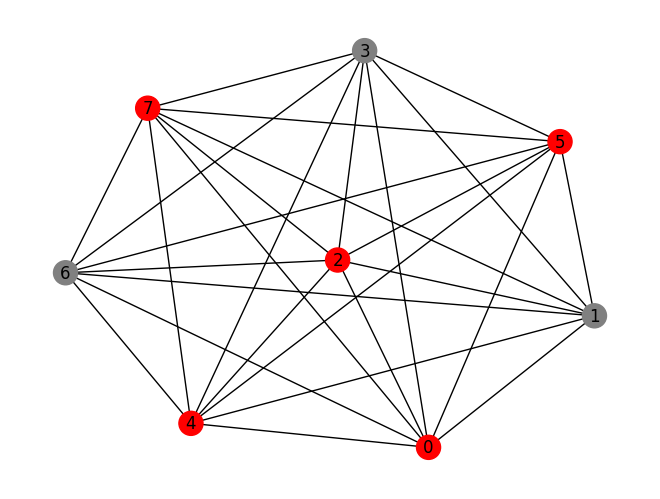

------------------------------
Aristas en riesgo:  []
Vertices infecciosos:  [0, 5, 4, 2, 7]
------------------------------
------------------------------
En la siguiente iteración ocurre: 
 	 *Se genera el tiempo 0.20391750478908335
	 *Se selecciona el canal 4, que significa recuperacion del individuo 7
------------------------------

 La grafica se ve asi: 


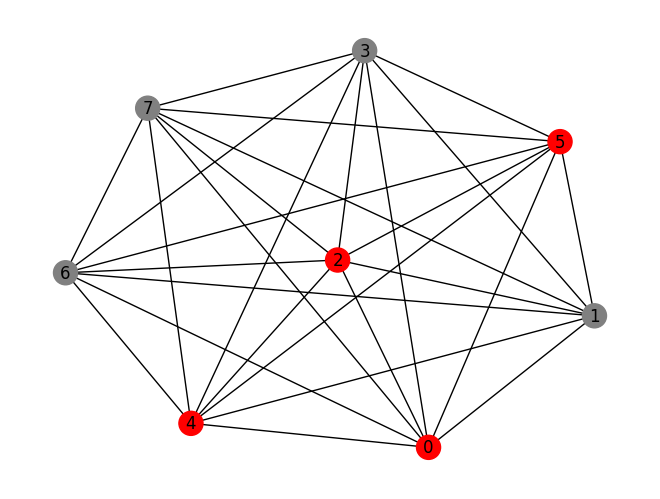

------------------------------
Aristas en riesgo:  []
Vertices infecciosos:  [0, 5, 4, 2]
------------------------------
------------------------------
En la siguiente iteración ocurre: 
 	 *Se genera el tiempo 0.4809141437710619
	 *Se selecciona el canal 0, que significa recuperacion del individuo 0
------------------------------

 La grafica se ve asi: 


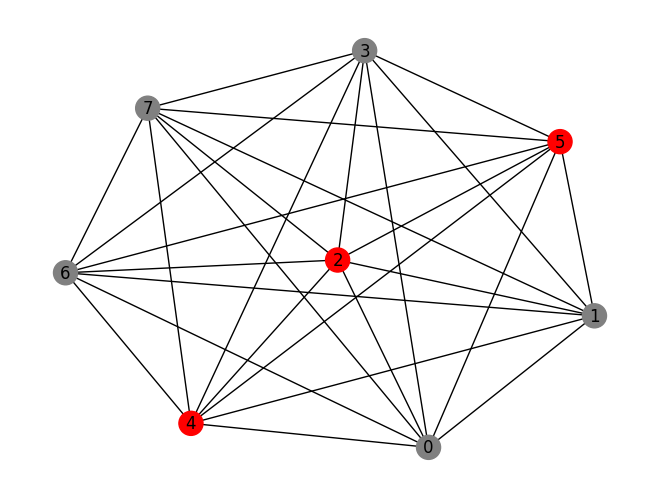

------------------------------
Aristas en riesgo:  []
Vertices infecciosos:  [5, 4, 2]
------------------------------
------------------------------
En la siguiente iteración ocurre: 
 	 *Se genera el tiempo 0.0963938059282373
	 *Se selecciona el canal 0, que significa recuperacion del individuo 5
------------------------------

 La grafica se ve asi: 


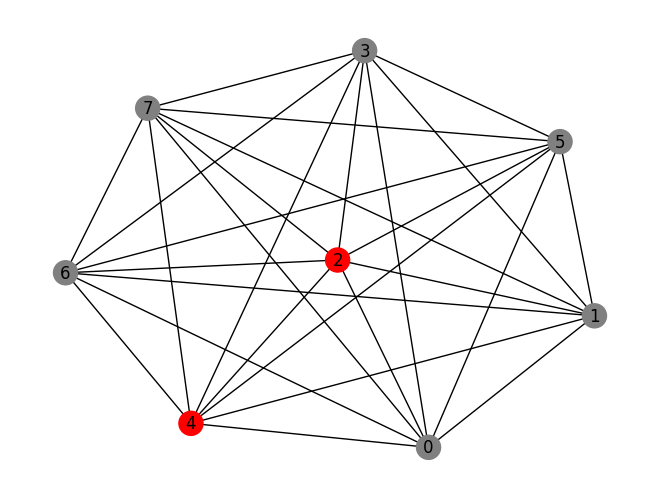

------------------------------
Aristas en riesgo:  []
Vertices infecciosos:  [4, 2]
------------------------------
------------------------------
En la siguiente iteración ocurre: 
 	 *Se genera el tiempo 0.5036227296813038
	 *Se selecciona el canal 1, que significa recuperacion del individuo 2
------------------------------

 La grafica se ve asi: 


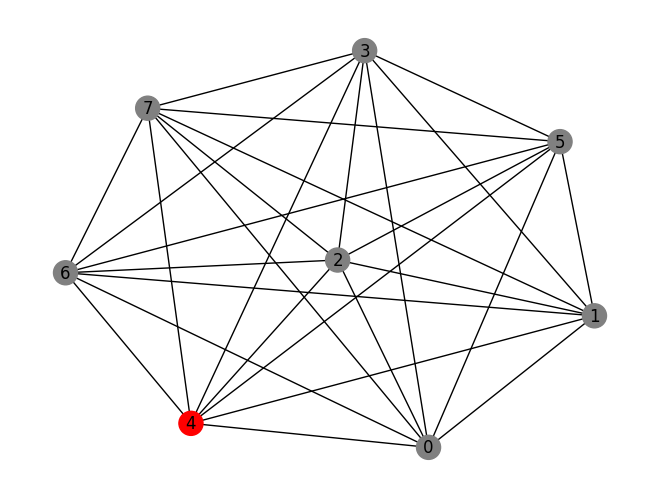

------------------------------
Aristas en riesgo:  []
Vertices infecciosos:  [4]
------------------------------
------------------------------
En la siguiente iteración ocurre: 
 	 *Se genera el tiempo 0.8519536647072868
	 *Se selecciona el canal 0, que significa recuperacion del individuo 4
------------------------------

 La grafica se ve asi: 


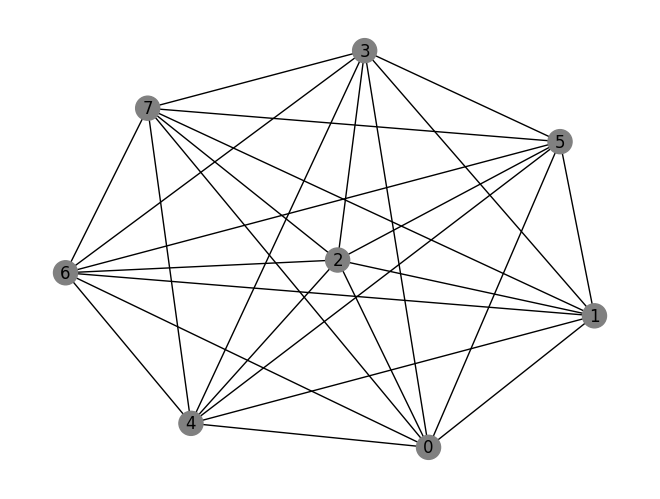

In [26]:
from scipy.optimize import fsolve
import networkx as nx
tipo='completa'
if tipo=='completa':
    N=8
    G=nx.complete_graph(N)
    pos=nx.spring_layout(G,seed=2)
else:
    N=10
    ksum=1
    np.random.seed(2)
    while(ksum%2!=0):#Que defina una grafica.
            k_dist=np.random.poisson(2,size=N)
            ksum=sum(k_dist)
    G=nx.random_degree_sequence_graph(k_dist)
    pos=nx.spring_layout(G,seed=2,k=3)
X_I_indexes=[0]
X_I=len(X_I_indexes)
for k in range(N):
    if k in X_I_indexes:
        G.nodes[k]['Estado:']='Infeccioso'
    else:
        G.nodes[k]['Estado:']='Susceptible'
#nx.draw(G, pos,with_labels=True,node_color=['r' if G.nodes[i]['Estado:']=='Infeccioso' else 'g' if G.nodes[i]['Estado:']=='Susceptible' else 'gray' for i in range(N)])
lammbda_I=1.25
a_I=1.2
lammbda_R=1
a_R=1.2
def pdf_Weibull_I(x,lammbda=lammbda_I,a=a_I):
    # a=1 es una exponencial.
    return (lammbda*a)*(lammbda*x)**(a-1)*np.exp(-(lammbda*x)**(a))
def survival_Weibull_I(x,lammbda=lammbda_I,a=a_I):
    return np.exp(-(lammbda*x)**(a))
def pdf_Weibull_R(x,lammbda=lammbda_R,a=a_R):
    # a=1 es una exponencial.
    return (lammbda*a)*(lammbda*x)**(a-1)*np.exp(-(lammbda*x)**(a))
def survival_Weibull_R(x,lammbda=lammbda_R,a=a_R):
    return np.exp(-(lammbda*x)**(a))
### Algoritmo 
#Paso 1.
t=0
aristas_en_riesgo={'arista':[],'tiempo':[]}
vertices_infecciosos={'vertice':[],'tiempo':[]}
#Llenar estos arreglos.
#N es el número de individuos.
for j in X_I_indexes:
    vertices_infecciosos['vertice'].append(j)
    vertices_infecciosos['tiempo'].append(0)
    for i in range(N):
        if G.has_edge(i,j):
            aristas_en_riesgo['arista'].append((min(i,j),max(i,j)))
            aristas_en_riesgo['tiempo'].append(0) 
print("Listas llenadas: ", aristas_en_riesgo,'\n',vertices_infecciosos)
flag=True
print("Así se ve la gráfica inicial: \n")
nx.draw(G, pos,with_labels=True,node_color=['r' if G.nodes[i]['Estado:']=='Infeccioso' else 'g' if G.nodes[i]['Estado:']=='Susceptible' else 'gray' for i in range(N)])
plt.show()
print("-"*20)
#---------------------------
count=0
Tuto=True
tau=0.2
while(flag):
    print("-"*30)
    print("Aristas en riesgo: ", aristas_en_riesgo['arista'])
    print("Vertices infecciosos: ", vertices_infecciosos['vertice'])
    print("-"*30)
    count+=1
    #Paso 2.
    #Definir \Phi(\tau|\{t_j\}):
    def Phi(tau):######Creo que se puede optimizar.
        Sum_1=np.sum([x**a_I-(tau+x)**a_I for x in aristas_en_riesgo['tiempo']])
        Sum_2=np.sum([x**a_R-(tau+x)**a_R for x in vertices_infecciosos['tiempo']])
        return np.exp((lammbda_I**(a_I))*(Sum_1)+(lammbda_R**(a_R))*Sum_2)
    #----------------------------
    def Phi_deriv(tau):
        sum=0
        for t_j in aristas_en_riesgo['tiempo']:
            sum+=(tau+t_j)**(a_I-1)
        sum=sum*a_I
        for t_j in vertices_infecciosos['tiempo']:
            sum+=(tau+t_j)**(a_R-1)
        sum=sum*a_R
        return Phi(tau)*(-sum)
    #----------------------------
    #Paso 3.
    #Generar el tiempo de siguiente reaccion:
    u=np.random.uniform()
    def Phi_u(tau):
        return Phi(tau)-u
    tau=fsolve(func=Phi_u,fprime=Phi_deriv,x0=tau/3)[0]
    #-------------------------
    #Paso 4. 
    #Definir las cantidades $\phi(\tau,i|t_i) 
    #Paso 5.
    #Calcular las probabilidades $\Pi_j$
    pi_s=phi_s/(np.sum(phi_s))
    pi_s_teoricas=[]
    for j in range(len(aristas_en_riesgo['tiempo'])):
        pi_s_teoricas.append(lammbda_I*a_I*(lammbda_I*(tau+aristas_en_riesgo['tiempo'][j]))**(a_I-1))
    for j in range(len(vertices_infecciosos['tiempo'])):
        pi_s_teoricas.append(lammbda_R*a_R*(lammbda_R*(tau+vertices_infecciosos['tiempo'][j]))**(a_R-1))
    pi_s=pi_s_teoricas/np.sum(pi_s_teoricas)
    #Paso 6.
    #Decidir el canal de reacción.
    u_2=np.random.uniform()
    D=pi_s[0]
    k=0
    while(u_2>D):
        k+=1
        D+=pi_s[k]
    #print(k," es el canal de reaccion seleccionado.")
    #--------------------------------
    #Paso 7 y 8.
    #Actualizacion de tiempos DESDE la ultima reaccion (en todos los canales)
    aristas_en_riesgo['tiempo']=[tau+x for x in aristas_en_riesgo['tiempo']]
    vertices_infecciosos['tiempo']=[tau+x for x in vertices_infecciosos['tiempo']]
    #------------
    #Identificar la reaccion:
    if(k<len(aristas_en_riesgo['tiempo'])):#Infeccion
        reaccion='infeccion'
        X_I+=1
        #arista
        arista_elegida=aristas_en_riesgo['arista'][k]
        involucrado_1,involucrado_2=arista_elegida[0],arista_elegida[1]
        #Identificar al nuevo infectado-------------
        if(G.nodes[involucrado_1]['Estado:']=='Susceptible'):
            #involucrado_1 es el nuevo infeccioso
            nuevo_infectado=involucrado_1
        else:
            nuevo_infectado=involucrado_2
        G.nodes[nuevo_infectado]['Estado:']='Infeccioso'#Actualizacion en el grafo.
        #--------------------------
        #Agregarlo a la lista vertices_infecciosos con tiempo 0----
        vertices_infecciosos['vertice'].append(nuevo_infectado)
        vertices_infecciosos['tiempo'].append(0)
        #-----------------------------
        #Agrega a la lista aristas_en_riesgo a aquellas nuevas aristas que podrían provocar una infección, con tiempo 0.
        for nei in G.neighbors(nuevo_infectado):
            if(G.nodes[nei]['Estado:']=='Susceptible'):
                aristas_en_riesgo['arista'].append((min(nei,nuevo_infectado),max(nei,nuevo_infectado)))
                aristas_en_riesgo['tiempo'].append(0)
            else:
                if(G.nodes[nei]['Estado:']=='Infeccioso'):
                    index=aristas_en_riesgo['arista'].index((min(nuevo_infectado,nei),max(nuevo_infectado,nei)))
                    aristas_en_riesgo['arista'].pop(index)
                    aristas_en_riesgo['tiempo'].pop(index)
        #-----------------------------
        #Elimina de la lista aristas_en_riesgo a la arista que provocó la nueva infeccion

        #-----------------------------
        nuevo_involucrado=nuevo_infectado
        #-----------------------------
        #Elimina de la lista aristas_en_riesgo a las aristas que ya no son viables. I.e. involucra a dos infecciosos.


        #-----------------------------
    else:#Recuperacion.
        X_I-=1
        reaccion='recuperacion'
        indice_respecto_vertices=k-len(aristas_en_riesgo['tiempo'])
        nuevo_recuperado=vertices_infecciosos['vertice'][indice_respecto_vertices]
        #Actualiza el estado a Recuperado.
        G.nodes[nuevo_recuperado]['Estado:']='Recuperado'#Actualizacion en el grafo.
        #-----------------------------
        #Elimina de la lista vertices_infecciosos al nuevo recuperado.
        vertices_infecciosos['vertice'].pop(indice_respecto_vertices)
        vertices_infecciosos['tiempo'].pop(indice_respecto_vertices)
        #-----------------------------
        #Elimina de la lista aristas_en_riesgo a aquellas aristas que involucran al nuevo recuperado.
        aristas_en_riesgo_copia=aristas_en_riesgo['arista'].copy()
        count=-1
        for l in range(len(aristas_en_riesgo_copia)):
            edge=aristas_en_riesgo_copia[l]
            if(edge[0]==nuevo_recuperado or edge[1]==nuevo_recuperado):
                count+=1
                aristas_en_riesgo['arista'].pop(l-count)
                aristas_en_riesgo['tiempo'].pop(l-count)
        #-----------------------------
        nuevo_involucrado=nuevo_recuperado
    if(Tuto):
        print("-"*30)
        print("En la siguiente iteración ocurre: \n \t *Se genera el tiempo "+str(tau)+"\n\t *Se selecciona el canal " +str(k)+ ", que significa "+reaccion+" del individuo " +str(nuevo_involucrado))
        print("-"*30)
        print("\n La grafica se ve asi: ")
        nx.draw(G, pos,with_labels=True,node_color=['r' if G.nodes[i]['Estado:']=='Infeccioso' else 'g' if G.nodes[i]['Estado:']=='Susceptible' else 'gray' for i in range(N)])
        plt.show()
    if(X_I==0):
        flag=False


<ipython-input-12-a88f47504a60>:65: RuntimeWarning: invalid value encountered in power
  Sum_1=np.sum([x**a_I-(tau+x)**a_I for x in aristas_en_riesgo['tiempo']])
<ipython-input-12-a88f47504a60>:66: RuntimeWarning: invalid value encountered in power
  Sum_2=np.sum([x**a_R-(tau+x)**a_R for x in vertices_infecciosos['tiempo']])
/usr/local/lib/python3.9/dist-packages/scipy/optimize/_minpack_py.py:178: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


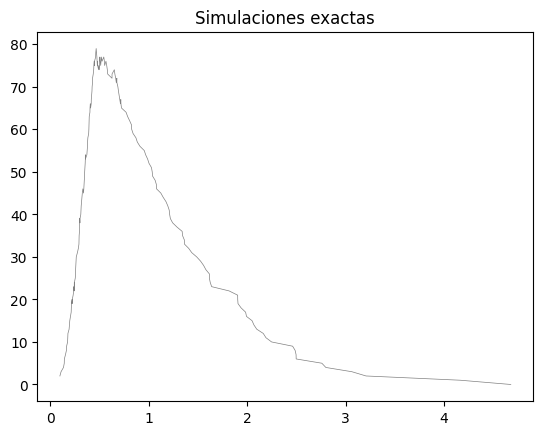

In [12]:
from scipy.optimize import fsolve
import networkx as nx
tipo=''
if tipo=='completa':
    N=8
    G=nx.complete_graph(N)
    pos=nx.spring_layout(G,seed=2)
else:
    N=100
    ksum=1
    np.random.seed(2)
    while(ksum%2!=0):#Que defina una grafica.
            k_dist=np.random.poisson(20,size=N)
            ksum=sum(k_dist)
    G=nx.random_degree_sequence_graph(k_dist)
    pos=nx.spring_layout(G,seed=2,k=3)
X_I_indexes=[0]
X_I=len(X_I_indexes)
for k in range(N):
    if k in X_I_indexes:
        G.nodes[k]['Estado:']='Infeccioso'
    else:
        G.nodes[k]['Estado:']='Susceptible'
#nx.draw(G, pos,with_labels=True,node_color=['r' if G.nodes[i]['Estado:']=='Infeccioso' else 'g' if G.nodes[i]['Estado:']=='Susceptible' else 'gray' for i in range(N)])
lammbda_I=1.25
a_I=1.2
lammbda_R=1
a_R=1.2
def pdf_Weibull_I(x,lammbda=lammbda_I,a=a_I):
    # a=1 es una exponencial.
    return (lammbda*a)*(lammbda*x)**(a-1)*np.exp(-(lammbda*x)**(a))
def survival_Weibull_I(x,lammbda=lammbda_I,a=a_I):
    return np.exp(-(lammbda*x)**(a))
def pdf_Weibull_R(x,lammbda=lammbda_R,a=a_R):
    # a=1 es una exponencial.
    return (lammbda*a)*(lammbda*x)**(a-1)*np.exp(-(lammbda*x)**(a))
def survival_Weibull_R(x,lammbda=lammbda_R,a=a_R):
    return np.exp(-(lammbda*x)**(a))
### Algoritmo 
#Paso 1.
t=0
aristas_en_riesgo={'arista':[],'tiempo':[]}
vertices_infecciosos={'vertice':[],'tiempo':[]}
#Llenar estos arreglos.
#N es el número de individuos.
for j in X_I_indexes:
    vertices_infecciosos['vertice'].append(j)
    vertices_infecciosos['tiempo'].append(0)
    for i in range(N):
        if G.has_edge(i,j):
            aristas_en_riesgo['arista'].append((min(i,j),max(i,j)))
            aristas_en_riesgo['tiempo'].append(0) 
flag=True

#---------------------------
count=0
Tuto=False
hist=[]
tau=0.5
while(flag):
    count+=1
    #Paso 2.
    #Definir \Phi(\tau|\{t_j\}):
    def Phi(tau):######Creo que se puede optimizar.
        Sum_1=np.sum([x**a_I-(tau+x)**a_I for x in aristas_en_riesgo['tiempo']])
        Sum_2=np.sum([x**a_R-(tau+x)**a_R for x in vertices_infecciosos['tiempo']])
        return np.exp((lammbda_I**(a_I))*(Sum_1)+(lammbda_R**(a_R))*Sum_2)
    #----------------------------
    def Phi_deriv(tau):
        sum=0
        for t_j in aristas_en_riesgo['tiempo']:
            sum+=(tau+t_j)**(a_I-1)
        sum=sum*a_I
        for t_j in vertices_infecciosos['tiempo']:
            sum+=(tau+t_j)**(a_R-1)
        sum=sum*a_R
        return Phi(tau)*(-sum)
    #----------------------------
    #Paso 3.
    #Generar el tiempo de siguiente reaccion:
    u=np.random.uniform()
    def Phi_u(tau):
        return Phi(tau)-u
    tau=fsolve(func=Phi_u,fprime=Phi_deriv,x0=tau/5)[0]
    t+=tau
    #-------------------------
    #Paso 4. 
    #Definir las cantidades $\phi(\tau,i|t_i) 
    #Paso 5.
    #Calcular las probabilidades $\Pi_j$
    #pi_s=phi_s/(np.sum(phi_s))
    pi_s_teoricas=[]
    for j in range(len(aristas_en_riesgo['tiempo'])):
        pi_s_teoricas.append(lammbda_I*a_I*(lammbda_I*(tau+aristas_en_riesgo['tiempo'][j]))**(a_I-1))
    for j in range(len(vertices_infecciosos['tiempo'])):
        pi_s_teoricas.append(lammbda_R*a_R*(lammbda_R*(tau+vertices_infecciosos['tiempo'][j]))**(a_R-1))
    pi_s=pi_s_teoricas/np.sum(pi_s_teoricas)
    #Paso 6.
    #Decidir el canal de reacción.
    u_2=np.random.uniform()
    D=pi_s[0]
    k=0
    while(u_2>D):
        k+=1
        D+=pi_s[k]
    #print(k," es el canal de reaccion seleccionado.")
    #--------------------------------
    #Paso 7 y 8.
    #Actualizacion de tiempos DESDE la ultima reaccion (en todos los canales)
    aristas_en_riesgo['tiempo']=[tau+x for x in aristas_en_riesgo['tiempo']]
    vertices_infecciosos['tiempo']=[tau+x for x in vertices_infecciosos['tiempo']]
    #------------
    #Identificar la reaccion:
    if(k<len(aristas_en_riesgo['tiempo'])):#Infeccion
        reaccion='infeccion'
        X_I+=1
        #arista
        arista_elegida=aristas_en_riesgo['arista'][k]
        involucrado_1,involucrado_2=arista_elegida[0],arista_elegida[1]
        #Identificar al nuevo infectado-------------
        if(G.nodes[involucrado_1]['Estado:']=='Susceptible'):
            #involucrado_1 es el nuevo infeccioso
            nuevo_infectado=involucrado_1
        else:
            nuevo_infectado=involucrado_2
        G.nodes[nuevo_infectado]['Estado:']='Infeccioso'#Actualizacion en el grafo.
        #--------------------------
        #Agregarlo a la lista vertices_infecciosos con tiempo 0----
        vertices_infecciosos['vertice'].append(nuevo_infectado)
        vertices_infecciosos['tiempo'].append(0)
        #-----------------------------
        #Agrega a la lista aristas_en_riesgo a aquellas nuevas aristas que podrían provocar una infección, con tiempo 0.
        for nei in G.neighbors(nuevo_infectado):
            if(G.nodes[nei]['Estado:']=='Susceptible'):
                aristas_en_riesgo['arista'].append((min(nei,nuevo_infectado),max(nei,nuevo_infectado)))
                aristas_en_riesgo['tiempo'].append(0)
            else:
                if(G.nodes[nei]['Estado:']=='Infeccioso'):
                    index=aristas_en_riesgo['arista'].index((min(nuevo_infectado,nei),max(nuevo_infectado,nei)))
                    aristas_en_riesgo['arista'].pop(index)
                    aristas_en_riesgo['tiempo'].pop(index)
        #-----------------------------
        #Elimina de la lista aristas_en_riesgo a la arista que provocó la nueva infeccion

        #-----------------------------
        nuevo_involucrado=nuevo_infectado
        #-----------------------------
        #Elimina de la lista aristas_en_riesgo a las aristas que ya no son viables. I.e. involucra a dos infecciosos.


        #-----------------------------
    else:#Recuperacion.
        X_I-=1
        reaccion='recuperacion'
        indice_respecto_vertices=k-len(aristas_en_riesgo['tiempo'])
        nuevo_recuperado=vertices_infecciosos['vertice'][indice_respecto_vertices]
        #Actualiza el estado a Recuperado.
        G.nodes[nuevo_recuperado]['Estado:']='Recuperado'#Actualizacion en el grafo.
        #-----------------------------
        #Elimina de la lista vertices_infecciosos al nuevo recuperado.
        vertices_infecciosos['vertice'].pop(indice_respecto_vertices)
        vertices_infecciosos['tiempo'].pop(indice_respecto_vertices)
        #-----------------------------
        #Elimina de la lista aristas_en_riesgo a aquellas aristas que involucran al nuevo recuperado.
        aristas_en_riesgo_copia=aristas_en_riesgo['arista'].copy()
        count=-1
        for l in range(len(aristas_en_riesgo_copia)):
            edge=aristas_en_riesgo_copia[l]
            if(edge[0]==nuevo_recuperado or edge[1]==nuevo_recuperado):
                count+=1
                aristas_en_riesgo['arista'].pop(l-count)
                aristas_en_riesgo['tiempo'].pop(l-count)
        #-----------------------------
        nuevo_involucrado=nuevo_recuperado
    if(Tuto):
        print("-"*30)
        print("En la siguiente iteración ocurre: \n \t *Se genera el tiempo "+str(tau)+"\n\t *Se selecciona el canal " +str(k)+ ", que significa "+reaccion+" del individuo " +str(nuevo_involucrado))
        print("-"*30)
        print("\n La grafica se ve asi: ")
        nx.draw(G, pos,with_labels=True,node_color=['r' if G.nodes[i]['Estado:']=='Infeccioso' else 'g' if G.nodes[i]['Estado:']=='Susceptible' else 'gray' for i in range(N)])
        plt.show()
    else:
        hist.append([t,X_I])
    if(X_I==0):
        flag=False
H=pd.DataFrame(hist,columns=['time','I(t)'])
plt.plot(H['time'],H['I(t)'], 'gray',linewidth=0.5)
plt.title('Simulaciones exactas')
plt.show()